<a href="https://colab.research.google.com/github/Nicole0906/DLI_Group_Assignment/blob/main/Nicole_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

# Change directory to the desired location in Google Drive
import os
os.chdir('/content/gdrive/MyDrive')


Mounted at /content/gdrive


Traning Model

--2025-08-22 08:33:03--  https://raw.githubusercontent.com/Nicole0906/DLI_Group_Assignment/main/Phishing_Legitimate_full%203.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1406307 (1.3M) [text/plain]
Saving to: ‘phishing_dataset.csv’

phishing_dataset.cs 100%[===================>]   1.34M  --.-KB/s    in 0.07s   

2025-08-22 08:33:04 (19.4 MB/s) - ‘phishing_dataset.csv’ saved [1406307/1406307]

✅ Dataset downloaded & loaded successfully!
Shape: (10000, 50)
Columns: ['id', 'NumDots', 'SubdomainLevel', 'PathLevel', 'UrlLength', 'NumDash', 'NumDashInHostname', 'AtSymbol', 'TildeSymbol', 'NumUnderscore', 'NumPercent', 'NumQueryComponents', 'NumAmpersand', 'NumHash', 'NumNumericChars', 'NoHttps', 'RandomString', 'IpAddress', 'DomainInSubdomains', 'DomainInPa

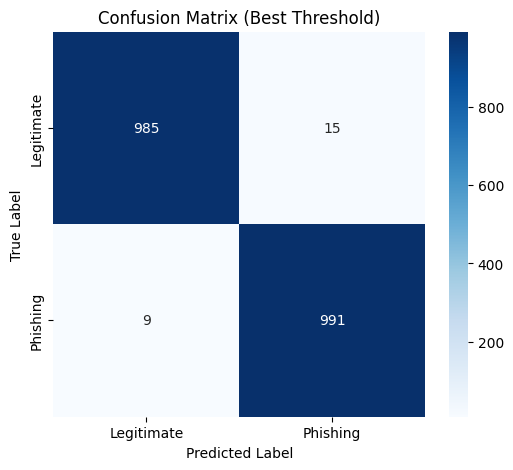

In [2]:
# ==============================
# STEP 1: Install dependencies
# ==============================
!pip install -q xgboost scikit-learn tabulate matplotlib seaborn

# ==============================
# STEP 2: Imports & Reproducibility
# ==============================
import os, random, time, subprocess
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)

# ==============================
# STEP 3: Download & Load dataset via wget from GitHub
# ==============================
DATA_URL = "https://raw.githubusercontent.com/Nicole0906/DLI_Group_Assignment/main/Phishing_Legitimate_full%203.csv"

!wget -O phishing_dataset.csv "$DATA_URL"

df = pd.read_csv("phishing_dataset.csv")
print("✅ Dataset downloaded & loaded successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.head())

# ==============================
# STEP 4: Define features & target
# ==============================
X = df.drop(columns=["id", "CLASS_LABEL"])
y = df["CLASS_LABEL"]
unique_labels = sorted(y.unique())
label_map = {0: "Legitimate", 1: "Phishing"}

# ==============================
# STEP 5: Train-test split
# ==============================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# ==============================
# STEP 6: Pipeline (Scaler + XGBoost)
# ==============================
xgb_model = xgb.XGBClassifier(
    n_estimators=800,
    learning_rate=0.03,
    max_depth=8,
    max_leaves=150,
    subsample=0.95,
    colsample_bytree=0.95,
    gamma=0.1,
    min_child_weight=2,
    random_state=SEED,
    eval_metric='logloss',
    n_jobs=1,
    reg_alpha=0.1,
    reg_lambda=1.0,
    max_delta_step=1
)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('model',  xgb_model)
])

print("\n🚀 Training Pipeline (Scaler + XGBoost)...")
pipeline.fit(X_train, y_train)

# ==============================
# STEP 7: Threshold tuning
# ==============================
start = time.time()
y_prob  = pipeline.predict_proba(X_test)[:,1]
inference_time = ((time.time() - start) / len(y_test)) * 1000.0

best_th, best_f1 = 0.5, 0
for th in np.arange(0.30, 0.71, 0.01):
    f1 = f1_score(y_test, (y_prob >= th).astype(int))
    if f1 > best_f1:
        best_f1, best_th = f1, th

y_pred_best = (y_prob >= best_th).astype(int)
report = classification_report(y_test, y_pred_best, output_dict=True, zero_division=0)
roc_auc = round(roc_auc_score(y_test, y_prob), 3)

# ==============================
# STEP 8: Format Params (main only)
# ==============================
params_str = f"trees={xgb_model.n_estimators}, max_depth={xgb_model.max_depth}"

# ==============================
# STEP 9: Evaluation Table
# ==============================
results_table = [[
    "XGBoost (with scaling)",
    round(report["accuracy"], 3),
    round(report["weighted avg"]["precision"], 3),
    round(report["weighted avg"]["recall"],    3),
    round(report["weighted avg"]["f1-score"],  3),
    roc_auc,
    params_str,            # ← main hyperparams only
    round(inference_time, 3)
]]

headers = ["Model","Accuracy","Precision","Recall","F1","ROC-AUC","Params","Inference (ms)"]
print(tabulate(results_table, headers=headers, tablefmt="grid"))
print(f"\nBest F1 = {best_f1:.3f}  @ Threshold = {best_th:.2f}")

# ==============================
# STEP 10: Confusion Matrix
# ==============================
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[label_map[i] for i in sorted(unique_labels)],
            yticklabels=[label_map[i] for i in sorted(unique_labels)])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Best Threshold)")
plt.show()
